In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Предобработка данных

In [2]:
df = pd.read_csv('diabetes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Визуализация

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

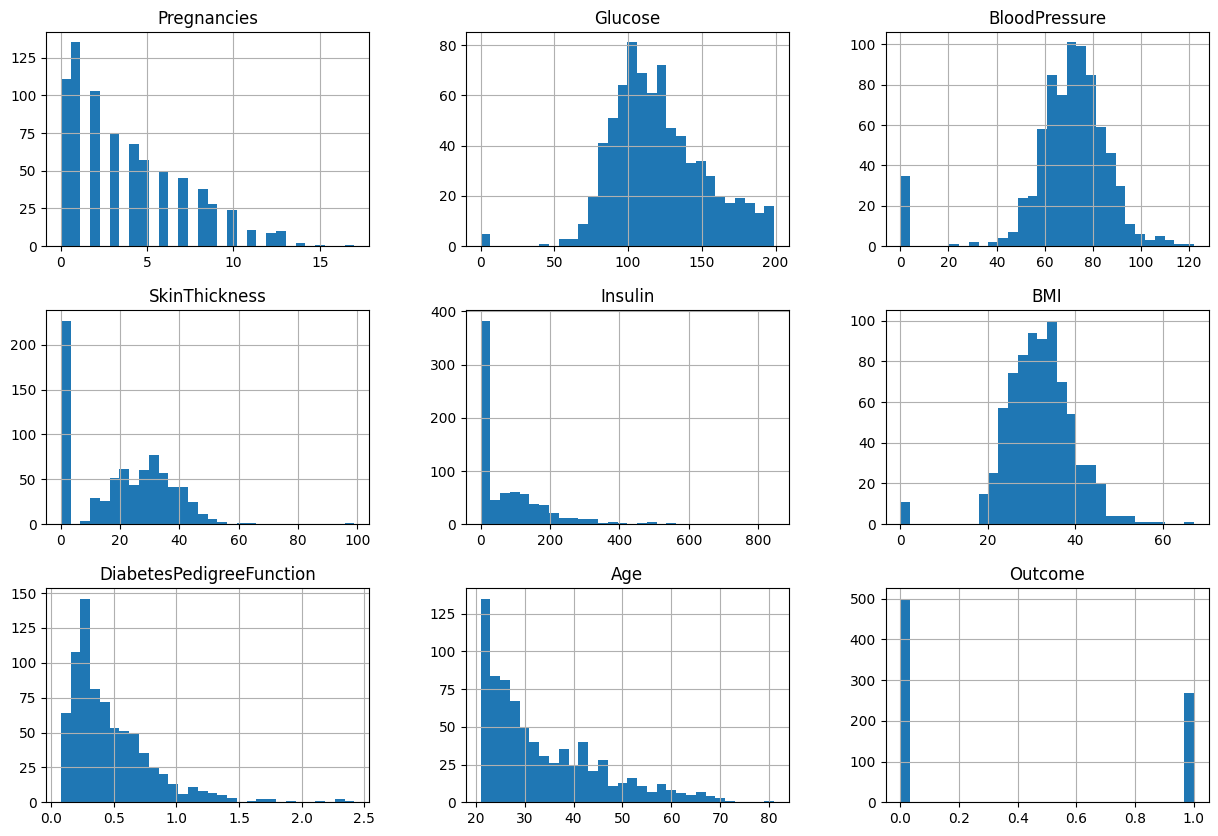

In [3]:
df.hist(bins=30, figsize=(15, 10))

## Нормализация

In [4]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [5]:
from sklearn.preprocessing import StandardScaler
def normalize(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)
X = normalize(X)
X.mean(), X.std()  # should be (0, 1)

(8.86154575644819e-17, 1.0)

## Logistic Regression

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

#### А сейчас будет страшно...

In [7]:
class LogisticRegression():
    def __init__(self, lr=0.001, n_iters=1000, sigma=0.0000000001, optimizer='gd'):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.sigma = sigma
        self.optimizer = optimizer

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        if (self.optimizer == 'gd'):
            for _ in range(self.n_iters):
                linear_model = np.dot(X, self.weights) + self.bias
                y_predicted = self._sigmoid(linear_model)
                self.gradient_descent(X, n_samples, y, y_predicted)
        if (self.optimizer == 'newton'):
            self.newtons_method(X, y)

    def gradient_descent(self, X, n_samples, y, predictions):
        dw, db = self.grad(X, n_samples, y, predictions)
        self.weights -= self.lr * dw
        self.bias -= self.lr * db

    def grad(self, X, n_samples, y, predictions):
        dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
        db = (1 / n_samples) * np.sum(predictions - y)
        return dw, db

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _sigmoid_linear(self, X):
        z = np.dot(X, self.weights) + self.bias
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def log_likelihood(self, X, y):
        sigmoid_probs = self._sigmoid_linear(X)
        return -np.sum(y * np.log(sigmoid_probs)
                      + (1 - y) * np.log(1 - sigmoid_probs))

    # g = X.T * (sigmoid_probs - y)
    def gradient(self, X, y, n_samples):
        sigmoid_probs = self._sigmoid_linear(X)
        return (1 / n_samples) * np.dot(X.T, (sigmoid_probs - y))

    # H = X.T * D * X
    # D = diag(sigmoid_probs * (1 - sigmoid_probs))
    def hessian(self, X, n_samples):
        sigmoid_probs = self._sigmoid_linear(X)
        H = (1 / n_samples) * np.dot(X.T, np.dot(np.diag(sigmoid_probs * (1 - sigmoid_probs)), X))
        return H

    def newtons_method(self, X, y):
        n_samples, n_features = X.shape

        # add bias to X
        X = np.column_stack((np.ones(n_samples), X))

        # n_features + 1 because of bias
        self.weights = np.zeros(n_features + 1)
        self.bias = 0


        i = 0
        dl = np.Infinity
        l = self.log_likelihood(X, y)
        while i < self.n_iters:
            i += 1
            g = self.gradient(X, y, n_samples)
            hess = self.hessian(X, n_samples)
            H_inv = np.linalg.inv(hess)
            delta = np.dot(H_inv, g)
            self.weights -= delta

            l_new = self.log_likelihood(X, y)
            dl = l_new - l
            l = l_new
            if abs(dl) < self.sigma:
                break

        # return everything as it was before) 
        self.bias = self.weights[0]
        self.weights = self.weights[1:]
        return self.weights, self.bias

    def _loss(self, y, y_predicted):
        y_predicted = np.clip(y_predicted, 1e-10, 1 - 1e-10)
        return - np.sum(y * np.log(y_predicted) + (1 - y) * np.log(1 - y_predicted))

In [8]:
def make_prediction(X_train, y_train, X_test, params):
    clf = LogisticRegression(params['lr'], params['n_iters'], params['sigma'], params['optimizer'])
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    return predictions

In [9]:
from metrics import accuracy, confusion_matrix
params = {'lr': 0.01, 'n_iters': 1000, 'sigma': 0.0000000001, 'optimizer': 'gd'}
y_pred = make_prediction(X_train, y_train, X_test, params)
accuracy(confusion_matrix(y_pred, y_test))

0.7532467532467533

In [10]:
from metrics import accuracy, confusion_matrix
params = {'lr': 0.01, 'n_iters': 1000, 'sigma': 0.0000000001, 'optimizer': 'newton'}
y_pred = make_prediction(X_train, y_train, X_test, params)
accuracy(confusion_matrix(y_pred, y_test))

0.7662337662337663

#### Проверочка)

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
def make_sklearn_prediction(X_train, y_train, X_test):
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    return predictions
sklearn_pred = make_sklearn_prediction(X_train, y_train, X_test)
print("Accuracy: ", accuracy_score(y_test, sklearn_pred))
print("Precision: ", precision_score(y_test, sklearn_pred))


Accuracy:  0.7727272727272727
Precision:  0.75


## Big Testing

In [13]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from time import time
import warnings
warnings.filterwarnings('ignore')
n_iters = np.arange(2, 300, 10)
lr = np.arange(0.001, 0.01, 0.003)
optimizer = ['gd', 'newton']
sigma = np.linspace(0.0000000001, 0.0000000001, 10)

print(f"Testing {len(n_iters) * len(lr) * len(optimizer) * len(sigma)} cases:")
start = time()
best_params_ac = {}
best_params_pre = {}
best_params_re = {}
best_params_f1 = {}
best_accuracy_score = 0
best_precision_score = 0
best_recall_score = 0
best_f1_score = 0

i = 0
for n_iter in n_iters:
    for lr_ in lr:
        for opt in optimizer:
            for sigma_ in sigma:
                case_start = time()

                clf = LogisticRegression(lr=lr_, n_iters=n_iter, sigma=sigma_, optimizer=opt)
                clf.fit(X_train, y_train)
                predictions = clf.predict(X_test)
                accuracy = accuracy_score(y_test, predictions)
                if accuracy > best_accuracy_score:
                    best_score = accuracy
                    best_params_ac  = {'n_iter': n_iter, 'lr': lr_, 'sigma': sigma_, 'optimizer': opt}
                
                precision = precision_score(y_test, predictions)
                if precision > best_precision_score:
                    best_precision_score = precision
                    best_params_pre = {'n_iter': n_iter, 'lr': lr_, 'sigma': sigma_, 'optimizer': opt}
                
                recall = recall_score(y_test, predictions)
                if recall > best_recall_score:
                    best_recall_score = recall
                    best_params_re = {'n_iter': n_iter, 'lr': lr_, 'sigma': sigma_, 'optimizer': opt}
                
                f1 = f1_score(y_test, predictions)
                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params_f1 = {'n_iter': n_iter, 'lr': lr_, 'sigma': sigma_, 'optimizer': opt}
                print(f"Case {i}: lr-{lr_}, n_iters-{n_iter}, sigma={sigma_}, optimizer={opt} finished in {time() - case_start}")
                print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
                i += 1
print(f"Testing finished in {time() - start} seconds")
print(f"Best accuracy score: {best_accuracy_score}, params: {best_params_ac}")
print(f"Best precision score: {best_precision_score}, params: {best_params_pre}")
print(f"Best recall score: {best_recall_score}, params: {best_params_re}")
print(f"Best f1 score: {best_f1_score}, params: {best_params_f1}")



Testing 2400 cases:
Case 0: lr-0.001, n_iters-2, sigma=1e-10, optimizer=gd finished in 0.06995391845703125
Accuracy: 0.7597402597402597, Precision: 0.6875, Recall: 0.6, F1: 0.6407766990291262
Case 1: lr-0.001, n_iters-2, sigma=1e-10, optimizer=gd finished in 0.04186606407165527
Accuracy: 0.7597402597402597, Precision: 0.6875, Recall: 0.6, F1: 0.6407766990291262
Case 2: lr-0.001, n_iters-2, sigma=1e-10, optimizer=gd finished in 0.01873183250427246
Accuracy: 0.7597402597402597, Precision: 0.6875, Recall: 0.6, F1: 0.6407766990291262
Case 3: lr-0.001, n_iters-2, sigma=1e-10, optimizer=gd finished in 0.02112722396850586
Accuracy: 0.7597402597402597, Precision: 0.6875, Recall: 0.6, F1: 0.6407766990291262
Case 4: lr-0.001, n_iters-2, sigma=1e-10, optimizer=gd finished in 0.02565908432006836
Accuracy: 0.7597402597402597, Precision: 0.6875, Recall: 0.6, F1: 0.6407766990291262
Case 5: lr-0.001, n_iters-2, sigma=1e-10, optimizer=gd finished in 0.01539301872253418
Accuracy: 0.7597402597402597, Pre